In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import os

csv_file_path = os.path.join(os.getcwd(), 'new_filtered_data.csv')
data = pd.read_csv(csv_file_path).iloc[::-1]
data['RSI'] = ta.rsi(data['Close'], length=7)
data['EMAF'] = ta.ema(data['Close'], length=14)

data.dropna(inplace=True)
# data = data.drop(data.index[:19])
print(data.head())

    Exchange Date    Close    Net        RSI         EMAF
322    2023-01-26  1093.83  10.70  87.052956  1073.585000
321    2023-01-27  1091.24  -2.59  78.272460  1075.939000
320    2023-01-30  1085.48  -5.76  62.037261  1077.211133
319    2023-01-31  1074.49 -10.99  42.441524  1076.848316
318    2023-02-01  1085.29  10.80  57.744220  1077.973873


## Process data 

In [2]:
data.dropna(inplace=True)
data.set_index('Exchange Date', inplace=True)
print(data.head())

                 Close    Net        RSI         EMAF
Exchange Date                                        
2023-01-26     1093.83  10.70  87.052956  1073.585000
2023-01-27     1091.24  -2.59  78.272460  1075.939000
2023-01-30     1085.48  -5.76  62.037261  1077.211133
2023-01-31     1074.49 -10.99  42.441524  1076.848316
2023-02-01     1085.29  10.80  57.744220  1077.973873


## Scale Data

In [3]:
from sklearn.preprocessing import MinMaxScaler

print(data.head(), end='\n\n')
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)
print(data_set_scaled[:10])

                 Close    Net        RSI         EMAF
Exchange Date                                        
2023-01-26     1093.83  10.70  87.052956  1073.585000
2023-01-27     1091.24  -2.59  78.272460  1075.939000
2023-01-30     1085.48  -5.76  62.037261  1077.211133
2023-01-31     1074.49 -10.99  42.441524  1076.848316
2023-02-01     1085.29  10.80  57.744220  1077.973873

[[0.84062865 0.70763698 0.98794689 0.76508609]
 [0.82472834 0.42648614 0.86978627 0.78257325]
 [0.78936706 0.35942458 0.65130643 0.79202355]
 [0.72189821 0.24878358 0.38760327 0.78932828]
 [0.78820063 0.70975249 0.59353426 0.79768972]
 [0.79378722 0.50052888 0.60801725 0.80583764]
 [0.74424458 0.31055638 0.44293484 0.80490589]
 [0.60457978 0.         0.18805249 0.78156465]
 [0.60869298 0.49545166 0.20148207 0.76199921]
 [0.63895881 0.58557224 0.30314783 0.74992562]]


## Separating data in batches

In [33]:
X = []
# how many data points to look behind at before predicting
# 28 because its the average number of days in a month - can be modified
lookback = 28

# go trough every column 

for j in range(len(data_set_scaled[0])):
    X.append([])
    # go trough every data 
    for i in range(lookback, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-lookback:i, j])
        
X = np.moveaxis(X, [0], [2])
Y = np.array(data_set_scaled[lookback:, -3])
Y = np.reshape(Y, (len(Y), 1))

print(X[:2])
print(Y[:1])

[[[0.84062865 0.70763698 0.98794689 0.76508609]
  [0.82472834 0.42648614 0.86978627 0.78257325]
  [0.78936706 0.35942458 0.65130643 0.79202355]
  [0.72189821 0.24878358 0.38760327 0.78932828]
  [0.78820063 0.70975249 0.59353426 0.79768972]
  [0.79378722 0.50052888 0.60801725 0.80583764]
  [0.74424458 0.31055638 0.44293484 0.80490589]
  [0.60457978 0.         0.18805249 0.78156465]
  [0.60869298 0.49545166 0.20148207 0.76199921]
  [0.63895881 0.58557224 0.30314783 0.74992562]
  [0.66443612 0.56907129 0.38402091 0.74357239]
  [0.59438885 0.23989846 0.25238102 0.72676473]
  [0.6078949  0.52781891 0.29749547 0.71437718]
  [0.60623734 0.4755659  0.29410419 0.70337387]
  [0.55159924 0.29299767 0.19222685 0.68502227]
  [0.58192645 0.5857838  0.30993831 0.67401059]
  [0.51826386 0.26189972 0.19687438 0.65419572]
  [0.55153785 0.59593823 0.31520402 0.6423913 ]
  [0.48535822 0.25322615 0.20475589 0.62148329]
  [0.41168887 0.22741697 0.11802549 0.59147709]
  [0.44115661 0.58282209 0.21658939 0.57

In [34]:
print(X.shape)
print(Y.shape)

(295, 28, 4)
(295, 1)


## Split data into train test sets

In [35]:
split = int(len(X) * 0.8)
X_train , X_test = X[:split], X[split:]
Y_train , Y_test = Y[:split], Y[split:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(236, 28, 4)
(59, 28, 4)
(236, 1)
(59, 1)


## LSTM Model

In [36]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(keras.__version__)

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
3.3.3


In [171]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

lstm_input = Input(shape=(lookback, len(data_set_scaled[0])), name='lstm_input')
inputs = LSTM(128, name='first_layer')(lstm_input)
# inputs = Dropout(0.2)(inputs)
# inputs = LSTM(64, name='second_layer')(inputs)
# inputs = Dropout(0.3)(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation(keras.activations.leaky_relu, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X, y=Y, batch_size=15, epochs=100, shuffle=True, validation_split=0.1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1030 - val_loss: 0.0636
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 - val_loss: 0.0325
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - val_loss: 0.0315
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0285 - val_loss: 0.0314
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.0302
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - val_loss: 0.0323
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329 - val_loss: 0.0375
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - val_loss: 0.0297
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - val_loss: 0.0301
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0279 - val_loss: 0.0282
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [172]:
from sklearn.metrics import root_mean_squared_error

prediction = model.predict(X_test)
rmse = root_mean_squared_error(Y_test, prediction)

print(rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
0.1665925064408806


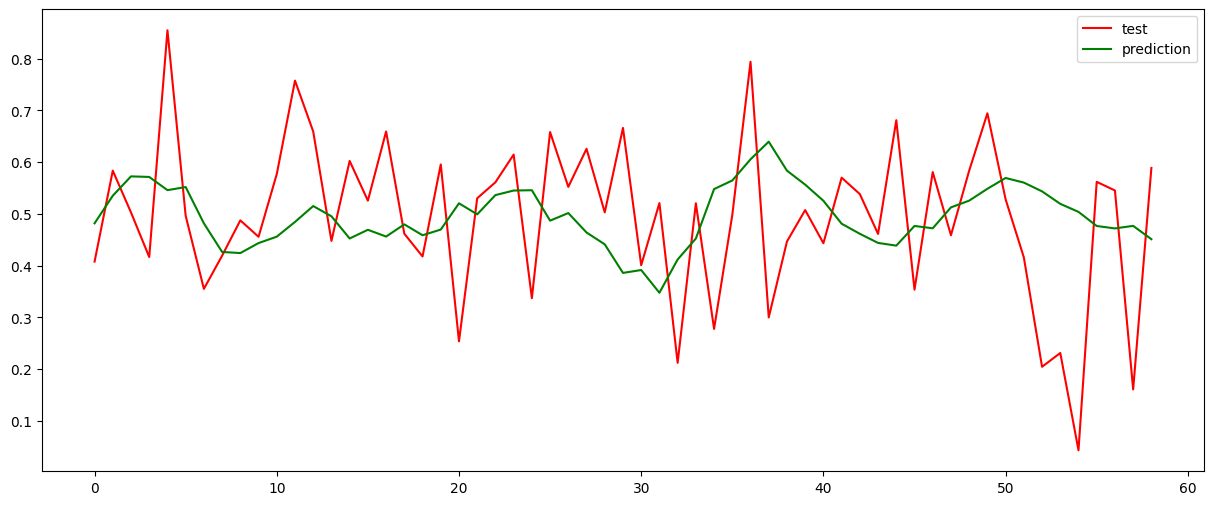

In [173]:
plt.figure(figsize=(15,6))
plt.plot(Y_test, color='red', label='test')
plt.plot(prediction, color='green', label='prediction')
plt.legend()
plt.show()

## Predict 5 days in a row 

In [194]:
last_five_days = []
last_row = np.array(X[-1], copy=True)

for _ in range(5):
    unscaled_prediction = np.array([0, model.predict(np.array([last_row]))[0][0], 0, 0])
    single_prediction = scaler.inverse_transform([unscaled_prediction])[0][1]
    print(single_prediction)
    
    last_row = scaler.inverse_transform(last_row) 
    last_row = np.delete(last_row, 0, 0)
    
    avg_rsi_ema = np.mean(last_row, axis=0)
    new_element = np.array([[last_row[-1][0] + single_prediction,
                             single_prediction,
                             np.nan,
                             np.nan]]
                           )
    
    # print(new_element)
    last_five_days.append(new_element[0][0])
    last_row = np.append(last_row, new_element, axis=0)
    
    scale_df = pd.DataFrame()
    scale_df['Close'] = last_row[:, 0] 
    scale_df['Net'] = last_row[:, 1] 
    scale_df['RSI'] = last_row[:, 2] 
    scale_df['EMAF'] = last_row[:, 3] 
    
    scale_df['RSI'] = ta.rsi(scale_df['Close'], length=7).iloc[-1]
    scale_df['EMAF'] = ta.ema(scale_df['Close'], length=14).iloc[-1]
    
    print(scale_df.iloc[-1])
    
    last_row = scaler.transform(scale_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-1.431139602959114
Close    1061.298860
Net        -1.431140
RSI        23.034890
EMAF     1085.532958
Name: 27, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
-7.166763378977745
Close    1054.132097
Net        -7.166763
RSI        19.879599
EMAF     1081.197037
Name: 27, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-7.370814609825581
Close    1046.761282
Net        -7.370815
RSI        16.958195
EMAF     1076.531628
Name: 27, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-7.524421113729447
Close    1039.236861
Net        -7.524421
RSI        14.508186
EMAF     1071.490284
Name: 27, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
-7.536313830018014
Close    1031.700547
Net        -7.536314
RSI        12.355571
EMAF     1066.179128
Name: 27, dtype: float64


In [191]:
print(last_five_days)

[1061.298860397041, 1054.1320970180632, 1046.7612824082375, 1039.2368612945081, 1031.70054746449]


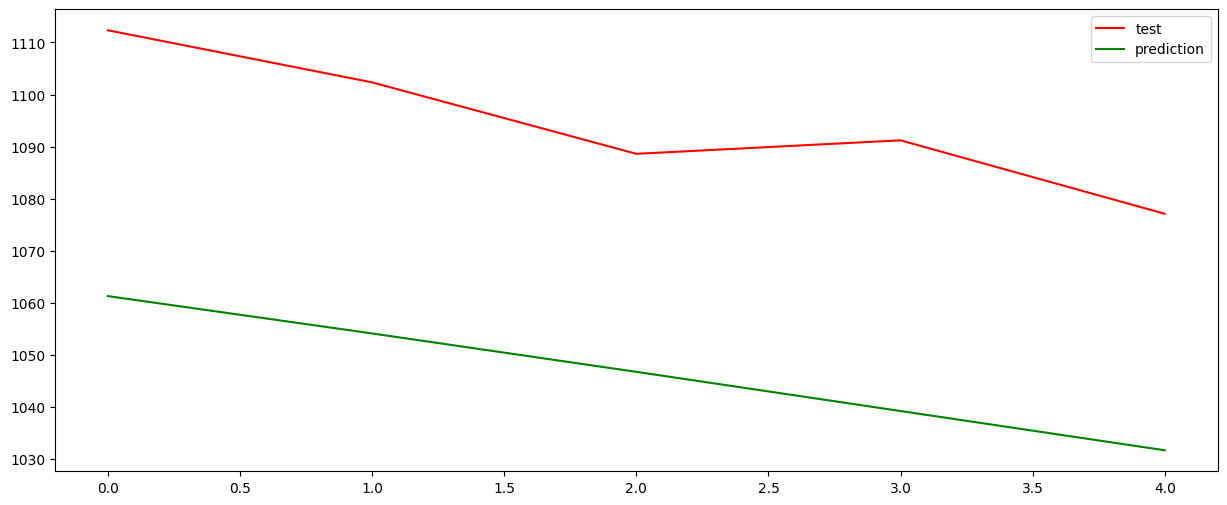

In [192]:
plt.figure(figsize=(15,6))
test_df = pd.DataFrame([1112.34, 1102.34, 1088.62, 1091.21, 1077.11])
last_five_days_df = pd.DataFrame(last_five_days)
plt.plot(test_df, color='red', label='test')
plt.plot(last_five_days, color='green', label='prediction')
plt.legend()
plt.show()